In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage, signal

import os
import pandas as pd

from skimage import morphology, graph, segmentation
import skfmm

import gudhi as gd

In [2]:
def read_binary_img(filename, threshold=100):
    bimg = cv2.imread(filename)[:,:,0]
    bimg[bimg < threshold] = 0
    bimg[bimg > 0] = 1
    bimg = bimg.astype(bool)

    return bimg

def clean_zeros_2d(img, pad=2):
    foo = np.nonzero(np.any(img, axis=0))[0]
    vceros = np.array([ max([0,foo[0] - pad]), min([img.shape[1], foo[-1]+pad]) ])
    
    foo = np.nonzero(np.any(img, axis=1))[0]
    hceros = np.array([ max([0,foo[0] - pad]), min([img.shape[0], foo[-1]+pad]) ])

    img = img[hceros[0]:hceros[1], vceros[0]:vceros[1]]
    
    return img, vceros, hceros

def pers2numpy(pers):
    bd = np.zeros((len(pers), 3), dtype=float)
    for i in range(len(bd)):
        bd[i, 0] = pers[i][0]
        bd[i, 1:] = pers[i][1]
    return bd

In [26]:
genotypes = ['CAL','MLB','222','299','517','521']
imtype = ['Diseased', 'Healthy', 'Binary']
runnum = 2
src = '../run{:02d}/'.format(runnum)
gdst = src + 'gudhi/'
if not os.path.isdir(gdst):
    os.mkdir(gdst)

gidx = 2
dfiles = sorted(glob(src + '{}*/*-{}*.jpg'.format(imtype[0], genotypes[gidx])))
hfiles = sorted(glob(src + '{}*/*-{}*.jpg'.format(imtype[1], genotypes[gidx])))
bfiles = sorted(glob(src + '{}*/*-{}*.jpg'.format(imtype[2], genotypes[gidx])))

print('Total number of files:\t{}'.format(len(dfiles)))
bfiles

Total number of files:	6


['../run02/Binary_Images/1-222-1 -M220_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/3-222-1-F-1358_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/3-222-2-M-1295_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/4-222-1-F-1-409_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/4-222-2-M-1-401_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/5-222-1-F-1- 065_ivc.jpg_Binary_roots.jpg']

In [4]:
idx = 5
print(bfiles[idx])
bimg = read_binary_img(bfiles[idx])
bname = os.path.splitext(os.path.split(bfiles[idx])[1])[0].split('_ivc')[0].replace(' ','')
if False:
    dimg = bimg*read_binary_img(dfiles[idx])
    himg = bimg*read_binary_img(hfiles[idx])
    simg = dimg + himg
    print('Pixels in binary but NOT in sum:\t{}'.format(np.sum(~simg*bimg)))
    print('Pixels in sum but NOT in binary:\t{}'.format(np.sum(~bimg*simg)))

../run02/Binary_Images/5-222-1-F-1- 065_ivc.jpg_Binary_roots.jpg


In [5]:
img = bimg.copy()
img = ndimage.binary_dilation(img, ndimage.generate_binary_structure(2,1), 3)
img, vceros, hceros = clean_zeros_2d(img)
print(vceros, hceros, sep='\n')

[1067 4020]
[   0 4727]


# Connect missing bits to the main component

In [6]:
label, nums = ndimage.label(img, structure=ndimage.generate_binary_structure(2,1))
print('Found',nums,'connected components')
hist, bins = np.histogram(label, bins=range(1,nums+2))
print(np.round(100*np.sort(hist)[::-1]/np.sum(hist),1))
print(np.sort(hist)[::-1])
hargsort = np.argsort(hist)[::-1]
thr = np.sum(100*hist/np.sum(hist) > 0.05)

main = img.copy()
main[label != bins[hargsort[0]]] = False
print('Largest label:\t', bins[hargsort[0]])
edt = ndimage.distance_transform_edt(~main, return_distances=False, return_indices=True)

Found 26 connected components
[95.   1.2  0.5  0.5  0.4  0.3  0.2  0.2  0.2  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
[891225  11095   4988   4797   3388   3195   1966   1741   1591   1388
   1200   1042   1032   1027    999    953    834    728    723    721
    710    626    576    564    562    481]
Largest label:	 1


In [7]:
pad = 5
gimg = img.copy()

rest = img.copy()
rest[label == bins[hargsort[0]]] = False
skel = morphology.skeletonize(rest)
g,nodes = graph.pixel_graph(skel, connectivity=2)

argleaf = np.nonzero(np.sum(g.A > 0, axis=0) == 1)[0]
leafx = nodes[argleaf]%skel.shape[1]
leafy = nodes[argleaf]//skel.shape[1]
leafz = label[leafy, leafx]

eidx = np.zeros((len(leafx), 2), dtype=int)
for i in range(len(eidx)):
    eidx[i] = edt[:, leafy[i], leafx[i]]

sdist = np.zeros(len(leafx))
for i in range(len(sdist)):
    sdist[i] = (leafx[i]-eidx[i,1])**2 + (leafy[i]-eidx[i,0])**2
sdist = np.sqrt(sdist)

for i in range(nums):
    dmask = leafz == i+1
    if np.sum(dmask) > 0:
        cidx = np.argmin(sdist[dmask])
        if sdist[dmask][cidx] < 250:
            p0 = np.array([leafx[dmask][cidx], leafy[dmask][cidx]])
            p1 = eidx[dmask][cidx][::-1]
            
            lams = np.linspace(0,1, 2*int(sdist[dmask][cidx]))
            
            for j in range(len(lams)):
                line = p0 + lams[j]*(p1 - p0)
                line = line.astype(int)
                gimg[ line[1]-pad:line[1]+pad, line[0]-pad:line[0]+pad] = True
        
        else:
            gimg[ label == i+1] = False
            print(i, sdist[dmask], sep='\t')

foo, bar = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
print('Found',bar,'connected components after processing')

Found 1 connected components after processing


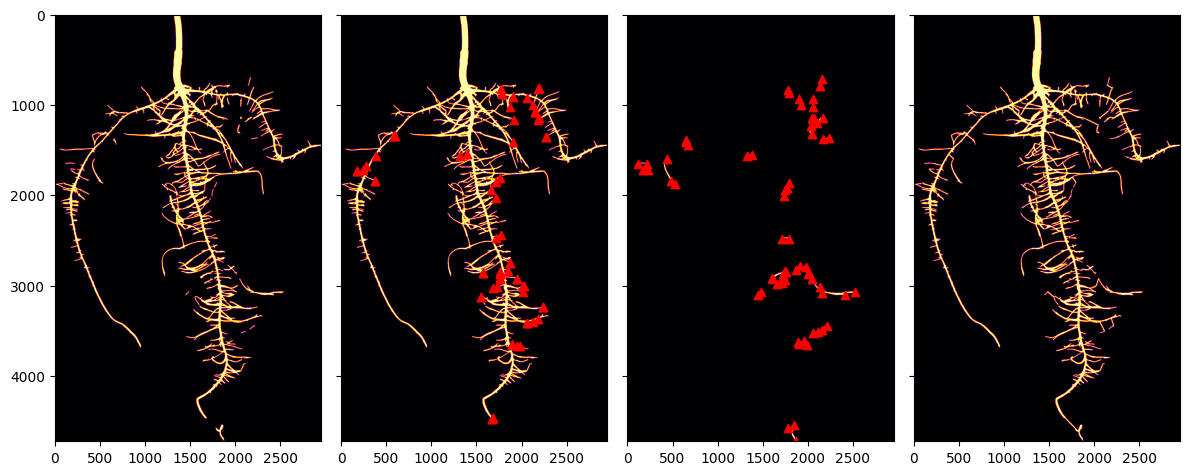

In [8]:
s = np.s_[3500:3600, 500:650]
fig, ax = plt.subplots(1,4, figsize=(12,9), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([img, main, rest, gimg]):
    ax[i].imshow(im, cmap='inferno', vmin=0, origin='upper')
    #ax[i].axvline(im.shape[1]/2, c='r')

ax[1].scatter(eidx[:,1], eidx[:,0], c='red', marker='^')
ax[2].scatter(leafx, leafy, c='red', marker='^')
#fig.delaxes(ax[-1])
fig.tight_layout()

# Compute the Geodesic Distance Transform

In [9]:
m = np.copy(gimg)
m[0, gimg[0] ] = False
m = np.ma.masked_array(m, ~gimg)

gdt = skfmm.distance(m).data

In [10]:
vdt = np.zeros(img.shape, dtype=int)
for i in range(len(vdt)):
    vdt[i] = i
vdt = vdt*gimg
ddt = gdt - vdt
print(np.min(ddt))
ddt[ddt < 0] = 0

-5.4228621593210846e-11


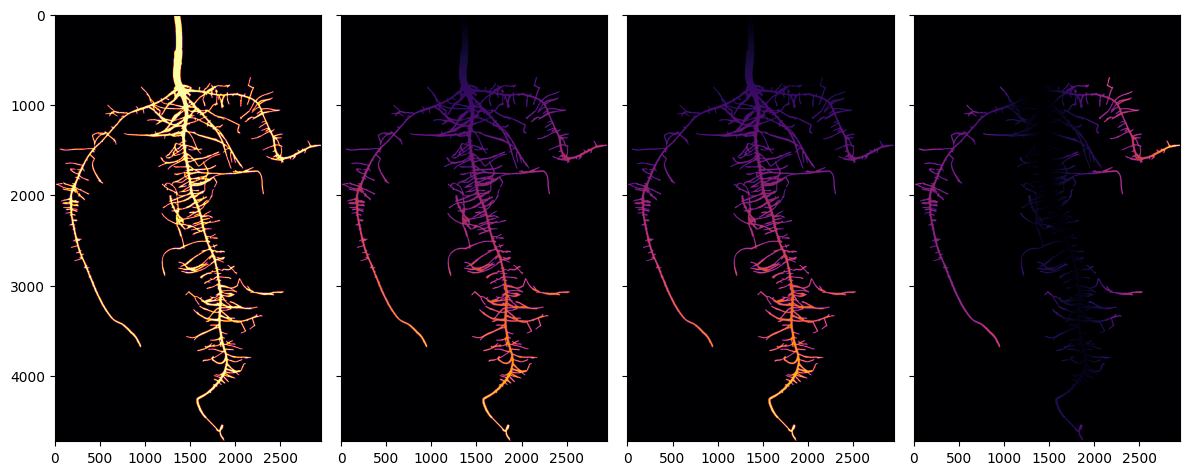

In [11]:
ss = np.s_[1550:1750, 450:650]
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

fig, ax = plt.subplots(1,4, figsize=(12,9), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([gimg, gdt, vdt, ddt]):
    ax[i].imshow(im, cmap='inferno', origin='upper')
    #ax[i].scatter(foo[1], foo[0], marker='.', color='r', alpha=0.1)
    #ax[i].set_xlim(extent[0],extent[1]); ax[i].set_ylim(extent[2],extent[3])
    #ax[i].axvline(ix[1] + .5, c='r'); ax[i].axhline(ix[0] + .5, c='r')

#fig.delaxes(ax[-1])
fig.tight_layout()

# Compute root tips via 0D persistence with geodesic filter

In [58]:
bd2lt

array([ 0, 41, 44, 45, 17, 47, 70, 34, 18, 46, 12, 32,  9, 43, 15, 14,  3,
       64, 68, 51, 59, 50, 38, 23, 13, 65,  6, 67, 53, 33, 48, 71, 36, 42,
       76, 75, 56, 77, 61, 26, 39, 66, 73, 11, 31,  4, 10, 62, 29, 69, 37,
       49, 58, 30, 72, 63, 52, 57, 16, 25, 28, 21, 19, 22, 55, 35, 54, 74,
       20,  8,  5, 40,  7,  2,  1, 27, 24, 60])

In [82]:
filename = gdst + bname + '_H0_diagram.csv'
print(filename)

if not os.path.isfile(filename):
    inv = np.max(gdt) - gdt
    cc = gd.CubicalComplex(top_dimensional_cells = inv)
    pers = cc.persistence(homology_coeff_field=2, min_persistence=100)
    cof = cc.cofaces_of_persistence_pairs()
    print(len(cof), len(cof[0]), len(cof[0][0]))
    print(len(cof), len(cof[0]), len(cof[0][1]))
    print(len(cof), len(cof[1]), len(cof[1][0]))
    
    tipx = np.hstack((cof[1][0][0]%gdt.shape[0], cof[0][0][:,0]%gdt.shape[0]))
    tipy = np.hstack((cof[1][0][0]//gdt.shape[0], cof[0][0][:,0]//gdt.shape[0]))
        
    bd = pers2numpy(pers)
    bd = np.atleast_2d(bd[np.all(bd < np.inf, axis=1), :]).squeeze()
    bd0 = bd[bd[:,0] == 0, 1:]
    bd0 = np.vstack(([0,np.max(gdt)], bd0))
    
    lt = bd0[:,1] - bd0[:,0]
    for i in [0,1]:
        print(i,np.sum(bd[:,0] == i), sep='\t')
    
    bd2lt = np.zeros(len(tipx), dtype=int)
    for i in range(len(tipx)):
        bd2lt[i] = np.argmin(np.abs(bd0[:,0] - inv[tipx[i], tipy[i]]))
    
    birthdeath = pd.DataFrame(bd0, columns=['birth','death'])
    birthdeath['tipx'] = tipx
    birthdeath['tipy'] = tipy
    birthdeath['lifetime'] = lt
    birthdeath['bd2lt'] = bd2lt
    birthdeath.to_csv(filename, index=False)

birthdeath = pd.read_csv(filename)
birthdeath.head()

../run02/gudhi/5-222-1-F-1-065_H0_diagram.csv


,birth,death,tipx,tipy,lifetime,bd2lt
0,0.000000,4983.637040,4725,1870,4983.637040,0
1,547.124816,3806.929350,3869,2110,3259.804534,41
2,2206.140756,3787.605403,3824,2071,1581.464647,44
3,1130.001591,1852.615191,3847,1632,722.613600,45
4,2265.728310,2984.648774,3804,2171,718.920464,17


In [81]:
filename = gdst + bname + '_H0_diagram.csv'
print(filename)
birthdeath = pd.DataFrame(bd0, columns=['birth','death'])
birthdeath['tipx'] = tipx
birthdeath['tipy'] = tipy
birthdeath['lifetime'] = lt
birthdeath['bd2lt'] = bd2lt
birthdeath.to_csv(filename, index=False)

../run02/gudhi/5-222-1-F-1-065_H0_diagram.csv


# Compute root tips via local maxima and watershed segmentation

In [13]:
mingeo = 0.5*img.shape[0]
maxfiltersize = 150
dilations = 5
mimg = ndimage.maximum_filter(gdt, size=maxfiltersize, mode='constant')

timg = (gdt == mimg) & (mimg > mingeo)
dimg = ndimage.binary_dilation(timg, ndimage.generate_binary_structure(2,2), dilations)

mlabel, mnums = ndimage.label(dimg, structure=ndimage.generate_binary_structure(2,2))
print('Found',mnums,'local maxima in dimg')
rawcoms = np.asarray(ndimage.center_of_mass(dimg, mlabel, index=range(1,mnums+1)))
rawcoms = rawcoms.astype(int)
watershed = segmentation.watershed(inv, markers=mlabel, mask=gimg)
hist, bins = np.histogram(watershed, bins=range(1,mnums+2))

Found 38 local maxima in dimg


In [70]:
print(lt.shape, bd2lt.shape, tipy.shape)

(79,) (78,) (78,)


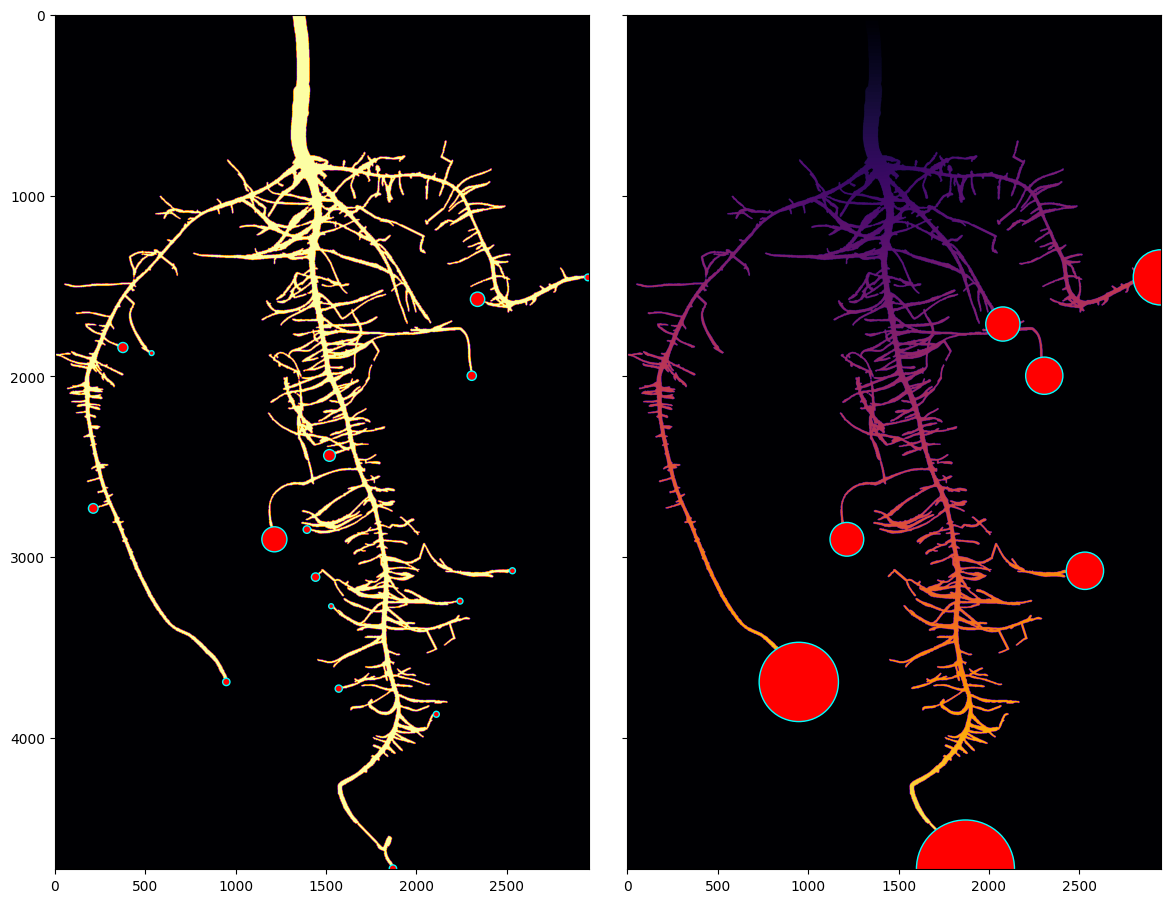

In [76]:
wsize = 1000*hist/np.sum(hist)
wsize[wsize < 10] = 0

psize = lt[bd2lt].copy()
psize[psize < 10
00] = 0

ss = np.s_[1550:1750, 450:650]
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

fig, ax = plt.subplots(1,2, figsize=(12,9), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

#for i,im in enumerate([gdt, gdt]):
ax[0].imshow(gimg, cmap='inferno', origin='upper', vmin=0)
ax[1].imshow(gdt, cmap='inferno', origin='upper')

ax[0].scatter(rawcoms[:,1], rawcoms[:,0], marker='o', color='r', s=wsize, edgecolor='cyan', linewidth=1)
ax[1].scatter(tipy, tipx, marker='o', color='r', s=psize, edgecolor='cyan', linewidth=1)
    #ax[i].set_xlim(extent[0],extent[1]); ax[i].set_ylim(extent[2],extent[3])
    #ax[i].axvline(ix[1] + .5, c='r'); ax[i].axhline(ix[0] + .5, c='r')
ax[0].margins(0)
#fig.delaxes(ax[-1])
fig.tight_layout()